In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import xgboost as xgb
import copy
%matplotlib inline

In [2]:
#test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')

##
train, test = train_test_split(train, test_size=0.3) 
##

train['date']=pd.to_datetime(train['date'], infer_datetime_format=True)
test['date']=pd.to_datetime(test['date'], infer_datetime_format=True)

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.isocalendar().week
train['day'] = train['date'].dt.day
train['week']=train['week'].astype(np.int64)

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['week'] = test['date'].dt.isocalendar().week
test['day'] = test['date'].dt.day
test['week']=test['week'].astype(np.int64)

In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 639100 entries, 332708 to 215604
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    639100 non-null  datetime64[ns]
 1   store   639100 non-null  int64         
 2   item    639100 non-null  int64         
 3   sales   639100 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 24.4 MB


In [4]:
test.head(266)

,date,store,item,sales
255978,2013-12-05,1,15,54
197699,2014-05-07,9,11,69
490783,2016-11-16,9,27,26
450982,2017-11-22,7,25,58
461628,2017-01-16,3,26,36
...,...,...,...,...
753608,2016-07-20,3,42,47
269174,2015-01-23,8,15,79
640097,2015-09-25,1,36,75
909017,2017-02-04,8,50,63


In [5]:
sales_real = test.pop('sales')

In [6]:

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekofyear'] = train['date'].dt.isocalendar().week
train['dayofweek'] = train['date'].dt.dayofweek
train['weekday'] = train['date'].dt.weekday
train['dayofyear'] = train['date'].dt.dayofyear
train['quarter'] = train['date'].dt.quarter
train['is_month_start'] = train['date'].dt.is_month_start
train['is_month_end'] =train['date'].dt.is_month_end
train['is_quarter_start'] = train['date'].dt.is_quarter_start
train['is_quarter_end'] = train['date'].dt.is_quarter_end
train['is_year_start'] = train['date'].dt.is_year_start
train['is_year_end'] = train['date'].dt.is_year_end
train['daily_avg']=train.groupby(['item','store','dayofweek'])['sales'].transform('mean')
train['monthly_avg']=train.groupby(['item','store','month'])['sales'].transform('mean')
train["mean_store_item_month"] = train.groupby(['month',"item","store"])["sales"].transform("mean")
train["item_month_sum"] = train.groupby(['month',"item"])["sales"].transform("sum") 
train["store_month_sum"] = train.groupby(['month',"store"])["sales"].transform("sum") 

daily_avg=train.groupby(['item','store','dayofweek'])['sales'].mean().reset_index()
monthly_avg=train.groupby(['item','store','month'])['sales'].mean().reset_index()
mean_store_item_month = train.groupby(['month','item','store'])['sales'].mean().reset_index()
item_month_sum=train.groupby(['month','item'])['sales'].sum().reset_index()
store_month_sum=train.groupby(['month','store'])['sales'].sum().reset_index()
train.dtypes

#Create mask for boolean values for train dataset
train['is_month_start'] = train['is_month_start'].replace({True: 1, False: 0})
train['is_month_end'] = train['is_month_end'].replace({True: 1, False: 0})
train['is_quarter_start'] = train['is_quarter_start'].replace({True: 1, False: 0})
train['is_quarter_end'] = train['is_quarter_end'].replace({True: 1, False: 0})
train['is_year_start'] = train['is_year_start'].replace({True: 1, False: 0})
train['is_year_end'] = train['is_year_end'].replace({True: 1, False: 0})

#convert float to int
train['daily_avg']=train['daily_avg'].astype(np.int64)
train['weekofyear']=train['weekofyear'].astype(np.int64)
train['monthly_avg']=train['monthly_avg'].astype(np.int64)
train['mean_store_item_month']=train['mean_store_item_month'].astype(np.int64)

In [7]:
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekofyear'] = test['date'].dt.isocalendar().week
test['dayofweek'] = test['date'].dt.dayofweek
test['weekday'] = test['date'].dt.weekday
test['dayofyear'] = test['date'].dt.dayofyear
test['quarter'] = test['date'].dt.quarter
test['is_month_start'] = test['date'].dt.is_month_start
test['is_month_end']= test['date'].dt.is_month_end
test['is_quarter_start'] = test['date'].dt.is_quarter_start
test['is_quarter_end'] = test['date'].dt.is_quarter_end
test['is_year_start'] = test['date'].dt.is_year_start
test['is_year_end'] = test['date'].dt.is_year_end
test.dtypes

date                datetime64[ns]
store                        int64
item                         int64
year                         int64
month                        int64
day                          int64
weekofyear                  UInt32
dayofweek                    int64
weekday                      int64
dayofyear                    int64
quarter                      int64
is_month_start                bool
is_month_end                  bool
is_quarter_start              bool
is_quarter_end                bool
is_year_start                 bool
is_year_end                   bool
dtype: object

In [8]:
#Create mask for boolean values for test dataset
test['is_month_start'] = test['is_month_start'].replace({True: 1, False: 0})
test['is_month_end'] = test['is_month_end'].replace({True: 1, False: 0})
test['is_quarter_start'] = test['is_quarter_start'].replace({True: 1, False: 0})
test['is_quarter_end'] = test['is_quarter_end'].replace({True: 1, False: 0})
test['is_year_start'] = test['is_year_start'].replace({True: 1, False: 0})
test['is_year_end'] = test['is_year_end'].replace({True: 1, False: 0})
test['is_year_end'] = test['is_year_end'].astype(str).astype(np.int64)

#Add sales column with merge/join function to test data
def merge(x,y,col,col_name):
    x =pd.merge(x, y, how='left', on=None, left_on=col, right_on=col,
            left_index=False, right_index=False, sort=True,
             copy=True, indicator=False,validate=None)
    
    x=x.rename(columns={'sales':col_name})
    return x

test=merge(test, daily_avg,['item','store','dayofweek'],'daily_avg')
test=merge(test, monthly_avg,['item','store','month'],'monthly_avg')
test=merge(test, mean_store_item_month, ['month','item','store'],'mean_store_item_month')
test=merge(test, item_month_sum,['month','item'],'item_month_sum')
test=merge(test, store_month_sum,['month','store'],'store_month_sum')

#convert float to int
test['daily_avg']=test['daily_avg'].astype(np.int64)
test['weekofyear']=test['weekofyear'].astype(np.int64)
test['monthly_avg']=test['monthly_avg'].astype(np.int64)
test['mean_store_item_month']=test['mean_store_item_month'].astype(np.int64)
test.dtypes

date                     datetime64[ns]
store                             int64
item                              int64
year                              int64
month                             int64
day                               int64
weekofyear                        int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
is_month_start                    int64
is_month_end                      int64
is_quarter_start                  int64
is_quarter_end                    int64
is_year_start                     int64
is_year_end                       int64
daily_avg                         int64
monthly_avg                       int64
mean_store_item_month             int64
item_month_sum                    int64
store_month_sum                   int64
dtype: object

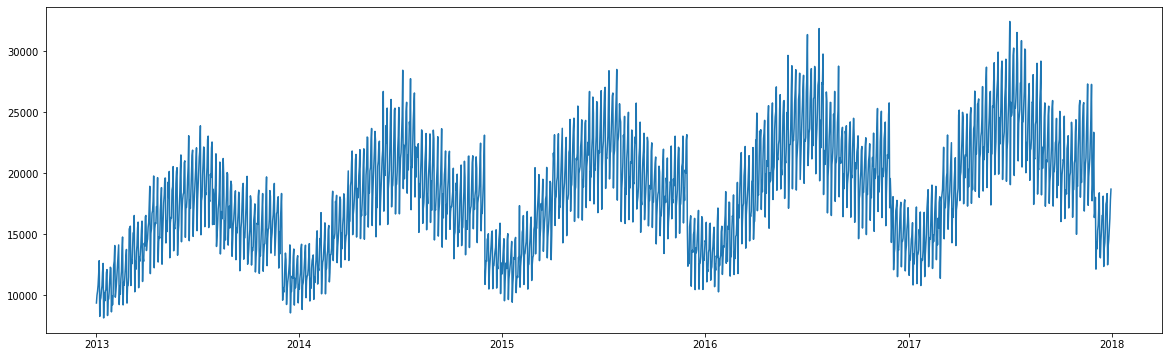

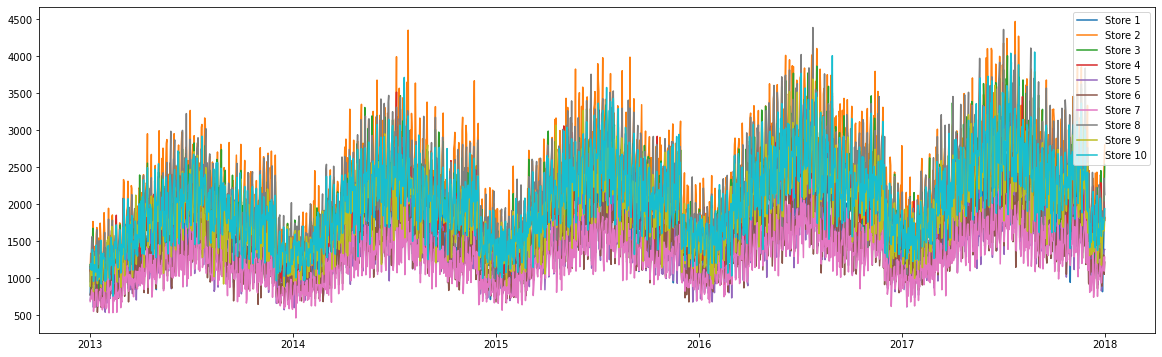

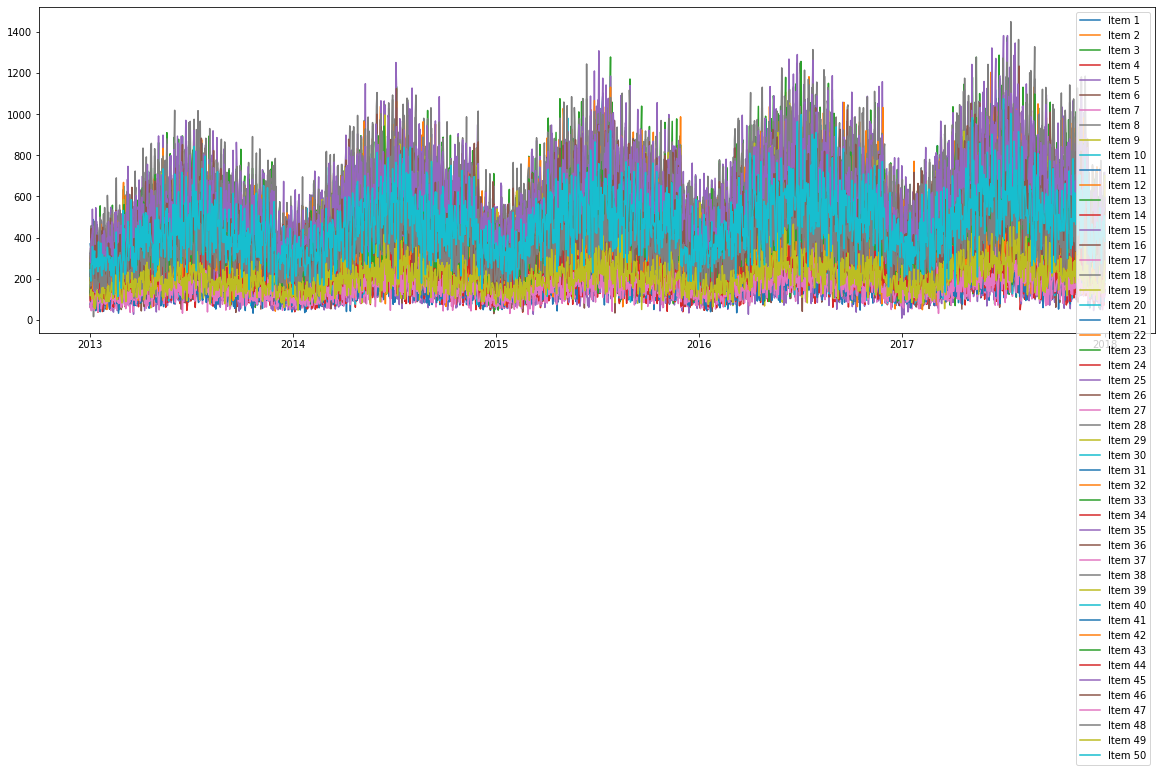

In [9]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

plt.figure('fig1',figsize=(20, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], )

plt.figure('fig2',figsize=(20, 6))
for store in store_daily_sales['store'].unique():
    temp = store_daily_sales[(store_daily_sales['store'] == store)]
    plt.plot(temp['date'], temp['sales'], label='Store %d' %store)
plt.legend(loc="upper right")

plt.figure('fig3',figsize=(20, 6))
for item in item_daily_sales['item'].unique():
    temp = item_daily_sales[(item_daily_sales['item'] == item)]
    plt.plot(temp['date'], temp['sales'], label='Item %d' %item)
plt.legend(loc="upper right")


In [10]:
test= test.drop(['date'], axis = 1)
train= train.drop(['date'], axis = 1)
train1= copy.deepcopy(train)
test1 = copy.deepcopy(test)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(train.drop('sales',axis=1),train.pop('sales'),random_state=42,test_size=0.2)

In [12]:
def XGBmodel(x_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params={'objective':'reg:squarederror','eval_metric':'mae'}
                  ,dtrain=matrix_train,num_boost_round=500, 
                    early_stopping_rounds=20,evals=[(matrix_test,'test')],)
    return model

model=XGBmodel(x_train,x_test,y_train,y_test)

[0]	test-mae:36.20455
[1]	test-mae:25.35765
[2]	test-mae:17.82279
[3]	test-mae:12.74664
[4]	test-mae:9.53568
[5]	test-mae:7.66704
[6]	test-mae:6.65011
[7]	test-mae:6.12141
[8]	test-mae:5.85492
[9]	test-mae:5.72063
[10]	test-mae:5.65572
[11]	test-mae:5.62338
[12]	test-mae:5.60733
[13]	test-mae:5.59888
[14]	test-mae:5.59502
[15]	test-mae:5.59283
[16]	test-mae:5.59176
[17]	test-mae:5.59056
[18]	test-mae:5.58981
[19]	test-mae:5.58982
[20]	test-mae:5.58872
[21]	test-mae:5.58873
[22]	test-mae:5.58785
[23]	test-mae:5.58737
[24]	test-mae:5.58668
[25]	test-mae:5.58623
[26]	test-mae:5.58577
[27]	test-mae:5.58550
[28]	test-mae:5.58429
[29]	test-mae:5.58365
[30]	test-mae:5.58363
[31]	test-mae:5.58357
[32]	test-mae:5.58315
[33]	test-mae:5.58280
[34]	test-mae:5.58233
[35]	test-mae:5.58220
[36]	test-mae:5.58160
[37]	test-mae:5.58162
[38]	test-mae:5.58149
[39]	test-mae:5.58157
[40]	test-mae:5.58144
[41]	test-mae:5.58146
[42]	test-mae:5.58136
[43]	test-mae:5.58110
[44]	test-mae:5.58093
[45]	test-mae:5.

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273900 entries, 0 to 273899
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   store                  273900 non-null  int64
 1   item                   273900 non-null  int64
 2   year                   273900 non-null  int64
 3   month                  273900 non-null  int64
 4   day                    273900 non-null  int64
 5   weekofyear             273900 non-null  int64
 6   dayofweek              273900 non-null  int64
 7   weekday                273900 non-null  int64
 8   dayofyear              273900 non-null  int64
 9   quarter                273900 non-null  int64
 10  is_month_start         273900 non-null  int64
 11  is_month_end           273900 non-null  int64
 12  is_quarter_start       273900 non-null  int64
 13  is_quarter_end         273900 non-null  int64
 14  is_year_start          273900 non-null  int64
 15  is_year_end      

In [14]:
y_pred = model.predict(xgb.DMatrix(test1), ntree_limit = model.best_ntree_limit)
test1['lag_value'] = y_pred

c:\users\kolhe\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [15]:
train1['lag_value'] = train1.groupby(["item","store"])['sales'].transform(lambda x:x.shift(365))
train1['lag_value'].fillna(train1['lag_value'].mode()[0], inplace=True)

#test1['store_item_shifted_365'] = test1.groupby(["item","store"])['sales'].transform(lambda x:x.shift(365))
#test1['store_item_shifted_365'].fillna(test1['store_item_shifted_365'].mode()[0], inplace=True)

In [16]:
x_train1,x_test1,y_train1,y_test1 = train_test_split(train1.drop('sales',axis=1),train1.pop('sales'),random_state=42,test_size=0.2)

In [17]:
model1=XGBmodel(x_train1,x_test1,y_train1,y_test1)

y_pred = model1.predict(xgb.DMatrix(test1), ntree_limit = model1.best_ntree_limit)


[0]	test-mae:36.20455
[1]	test-mae:25.35765
[2]	test-mae:17.82279
[3]	test-mae:12.74664
[4]	test-mae:9.53568
[5]	test-mae:7.66704
[6]	test-mae:6.65011
[7]	test-mae:6.12141
[8]	test-mae:5.85492
[9]	test-mae:5.72064
[10]	test-mae:5.65565
[11]	test-mae:5.62334
[12]	test-mae:5.60750
[13]	test-mae:5.59895
[14]	test-mae:5.59540
[15]	test-mae:5.59324
[16]	test-mae:5.59243
[17]	test-mae:5.59169
[18]	test-mae:5.59084
[19]	test-mae:5.58922
[20]	test-mae:5.58861
[21]	test-mae:5.58821
[22]	test-mae:5.58753
[23]	test-mae:5.58697
[24]	test-mae:5.58647
[25]	test-mae:5.58640
[26]	test-mae:5.58580
[27]	test-mae:5.58579
[28]	test-mae:5.58573
[29]	test-mae:5.58580
[30]	test-mae:5.58602
[31]	test-mae:5.58501
[32]	test-mae:5.58499
[33]	test-mae:5.58487
[34]	test-mae:5.58482
[35]	test-mae:5.58481
[36]	test-mae:5.58491
[37]	test-mae:5.58443
[38]	test-mae:5.58423
[39]	test-mae:5.58453
[40]	test-mae:5.58461
[41]	test-mae:5.58408
[42]	test-mae:5.58399
[43]	test-mae:5.58382
[44]	test-mae:5.58391
[45]	test-mae:5.

c:\users\kolhe\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [28]:
sales_pred = model.predict(xgb.DMatrix(test), ntree_limit = model1.best_ntree_limit)

c:\users\kolhe\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [29]:
sp = pd.DataFrame(sales_pred)
sp.head()

,0
0,10.136374
1,9.097422
2,10.612425
3,10.546093
4,11.505540


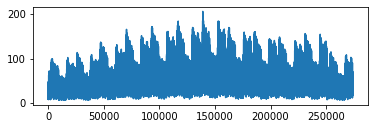

In [30]:
plt.figure('fig1',figsize=(6, 1.8))
plt.plot(sp) 